# Lab 8: Regression

In [1]:
!pip install pingouin --upgrade

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import pingouin as pg
import statsmodels.api as sm
pd.options.display.float_format = '{:.4f}'.format

In [3]:
#Show our plots in the Jupyter notebook
%matplotlib inline

In [4]:
#When we start working with nan (missing) values, we can get warnings - we're going to ignore them here
#You might not want to do this the first time around to see "under the hood" a bit more
import warnings
warnings.filterwarnings("ignore") 

## 1.0 Bring .csv into Python

In [5]:
df=pd.read_csv('Final_CP201Asurveydata.csv', delimiter = ',')

In [6]:
df

,Unnamed: 0,Survey Number,Day of the Week,Time of Day,Interviewer or self-administered,City,Neighborhood,Connection to neighborhood,Average days spent in neighborhood per week,Neighborhood recovered from pandemic,...,Support increasing the supply of housing,Support speed enforcement cameras,Support sales tax to fund climate disaster preparedness,Support investment in policing,Race/ethnicity,Age,Gender identity,Rent or own,Biggest challenge facing city,"Notes (include data here on ""Other"" responses, observational notes.)"
0,Safaeinili,RS1,Wednesday,PM,Self-administered,Berkeley,Downtown Berk (BART),Work,2,Strongly Disagree,...,Strongly Agree,Agree,Agree,Disagree,White,25-44 years old,Male,Own,Availability and affordability of housing,NaN
1,Safaeinili,RS2,Wednesday,PM,Self-administered,Berkeley,Downtown Berk (BART),Work,2,Agree,...,Strongly Agree,Strongly Disagree,Agree,Strongly Disagree,Hispanic/Latinx,25-44 years old,Female,Rent,Housing and infrastructure,NaN
2,Safaeinili,RS3,Wednesday,PM,Self-administered,Berkeley,Downtown Berk (BART),Other,7,Don't Know/NA,...,Strongly Disagree,Don't Know/NA,Don't Know/NA,Don't Know/NA,Black or African American,Under 25 years old,Male,Other,Increase of rent,live with parents
3,Safaeinili,RS4,Wednesday,PM,Self-administered,Berkeley,Downtown Berk (BART),Live,7,Don't Know/NA,...,Agree,Agree,Agree,Don't Know/NA,White,Under 25 years old,Female,Rent,"Poor drivers, dangerous crosswalks",NaN
4,Safaeinili,RS5,Wednesday,PM,Self-administered,Berkeley,Downtown Berk (BART),Live,7,Disagree,...,Agree,Agree,Agree,Agree,White,Under 25 years old,Female,Rent,NaN,Live in dorm owned by UC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,De Mott,JD01,Monday,PM,Self-administered,Oakland,West Oakland,Other,3,Disagree,...,Strongly Disagree,Agree,Neutral,Neutral,Hispanic/Latinx,25-44 years old,Female,Rent,NaN,NaN
192,De Mott,JD02,Monday,PM,Self-administered,Oakland,West Oakland,Other,2,Neutral,...,Strongly Agree,Strongly Agree,Neutral,Neutral,Hispanic/Latinx,Under 25 years old,Female,Rent,NaN,NaN
193,De Mott,JD03,Tuesday,PM,Self-administered,Berkeley,North Berkeley,Live,7,Agree,...,Strongly Agree,Disagree,Strongly Agree,Disagree,White,45-64 years old,Female,Own,Housing,NaN
194,De Mott,JD04,Tuesday,PM,Self-administered,Berkeley,North Berkeley,Other,1,Neutral,...,Agree,Agree,Neutral,Agree,White,65 or older,Female,Own,Crime,Had a great conversation about respondent's ti...


## 2. Cleaning and recoding data

You should be familiar with the codes below. I'm just going to go through the steps, without any explanatory text.

In [7]:
df.rename(columns={'Survey Number': 'survey_num', 
                        'Day of the Week': 'day_of_week', 
                        'Time of Day': 'time',
                        'Interviewer or self-administered': 'collection_mode',
                        'Connection to neighborhood': 'connection_nbhd',
                        'Average days spent in neighborhood per week': 'days_week',
                        'Neighborhood recovered from pandemic': 'pandemic_recover',
                        'Safe walking alone at night': 'safe_walking',
                        'New housing has increased gentrification': 'gentrification',
                        'Bikes lanes have increased traffic safety': 'bike_lane',
                        'I feel connected to the people and community in this city.': 'connected',
                        'Support increasing the supply of housing': 'housing_supply',
                        'Support speed enforcement cameras': 'speed_camera',
                        'Support sales tax to fund climate disaster preparedness': 'climate_tax',
                        'Support investment in policing': 'policing', 
                        'Gender identity': "gender_identity",
                        'Rent or own': 'tenure',
                        'Biggest challenge facing city': 'biggest_challenge',
                       'Race/ethnicity':'race_eth',
                        'Notes (include data here on "Other" responses, observational notes.)': 'notes'}, inplace=True)

### 2.1 Create outcome (dependent) variable: Housing supply numeric and dummy

In [8]:
df[['housing_supply']].value_counts(dropna=False)

housing_supply   
Agree                84
Strongly Agree       58
Neutral              23
Disagree             16
Strongly Disagree    12
Don't Know/NA         2
NaN                   1
Name: count, dtype: int64

In [9]:
#supply numeric - higher value = agree more strongly
df['supplyagree_numeric']=df['housing_supply'].map({"Strongly Agree":5, "Agree": 4, "Neutral": 3,
                                                                   "Disagree":2, "Strongly Disagree": 1, "Don't Know/NA":0})

In [10]:
#supply dummy - agree =1, else 0
df['supplyagree_dv']=df['housing_supply'].map({"Strongly Agree":1, "Agree": 1, "Neutral": 0,
                                                                   "Disagree":0, "Strongly Disagree": 0, "Don't Know/NA":0})

### 2.2 Create explanatory (independent) variables: Tenure, Age, Gender, and Gentrification

In [11]:
#owner dummy variable
df['own_dv']=df['tenure'].map({"Own": 1, "Other":1, "Rent":0})

In [12]:
#male dummy variable
df['male_dv']=df['gender_identity'].map({"Male": 1, "Female":0, "Non-binary":0, "Other/Prefer not to answer":0})

In [13]:
#age dummy variable - creating one for under 45
df['under45_dv']=df['Age'].map({"25-44 years old": 1, "45-64 years old":0, "65 or older":0, "Prefer not to answer":0, 'Under 25 years old':1})

In [14]:
#gentrification - I'm going to construct this as numeric, to demonstrate correlation
#gentrification numeric - higher value = agree more strongly
df['gentrifyagree_numeric']=df['gentrification'].map({"Strongly Agree":5, "Agree": 4, "Neutral": 3,
                                                                   "Disagree":2, "Strongly Disagree": 1, "Don't Know/NA":0})

## 3 Correlation

The correlation coefficient (sometimes referred to as Pearson's correlation coefficient, Pearson's product-moment correlation, or simply r) measures the strength of the linear relationship between two variables. 

The correlation coefficient is directly linked to the beta coefficient in a linear regression (= the slope of a best-fit line), but has the advantage of being standardized between -1 to 1 ; the former meaning a perfect negative linear relationship, and the latter a perfect positive linear relationship. In other words, no matter what are the original units of the two variables are, the correlation coefficient will always be in the range of -1 to 1, which makes it very easy to work with.

The correlation coefficient *r*

> The correlation coefficient ranges from −1 to 1. A value of 1 implies that a linear equation describes the relationship between X and Y perfectly, with all data points lying on a line for which Y increases as X increases. A value of −1 implies that all data points lie on a line for which Y decreases as X increases. A value of 0 implies that there is no linear relationship between the variables. 

In hypothesis testing, you want to find not only the correlation coefficient (the r value) but also the p-value.

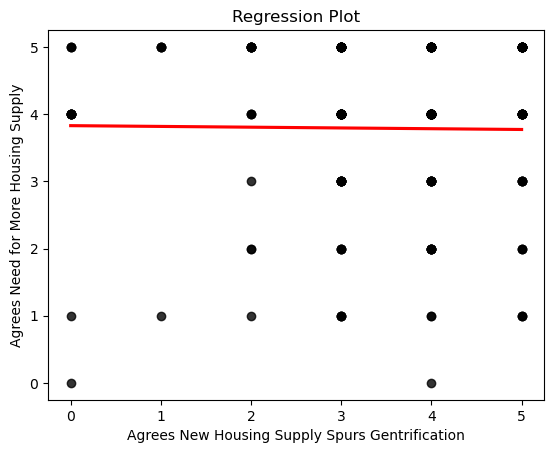

In [15]:
#Let's start by plotting the two numeric variables
sns.regplot(
    x=df["gentrifyagree_numeric"],  
    y=df["supplyagree_numeric"],   
    ci=None, 
    scatter_kws={"color": "black"}, 
    line_kws={"color": "red"}
)

plt.xlabel("Agrees New Housing Supply Spurs Gentrification")
plt.ylabel("Agrees Need for More Housing Supply")
plt.title("Regression Plot")
plt.show()

In [16]:
#Let's run our correlation test
pg.corr(x=df['gentrifyagree_numeric'], y=df["supplyagree_numeric"])

,n,r,CI95%,p-val,BF10,power
pearson,195,-0.0125,"[-0.15, 0.13]",0.8620,0.091,0.0534


Not suprising that we don't see a very large r or significant p-value - there's almost no slope to the line

## 4. Linear Regression

Linear regression is just an extension of correlation.  Let's take a look!

In [17]:
import statsmodels.formula.api as smf

# List of independent variables
ind_vars = ['own_dv', 'male_dv']

# Build the formula string automatically
formula = 'supplyagree_numeric ~ ' + ' + '.join(ind_vars)

# Run regression (missing='drop' handles NaNs)
model = smf.ols(formula=formula, data=df, missing='drop').fit()

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     supplyagree_numeric   R-squared:                       0.020
Model:                             OLS   Adj. R-squared:                  0.010
Method:                  Least Squares   F-statistic:                     1.923
Date:                 Wed, 26 Nov 2025   Prob (F-statistic):              0.149
Time:                         12:25:50   Log-Likelihood:                -299.79
No. Observations:                  189   AIC:                             605.6
Df Residuals:                      186   BIC:                             615.3
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9056      0.126     31.03

Cool!  We find that even after controlling for the male_dv (which is not significant, suggesting that male respondents did not agree with the need for more housing supply than those who did not identify as male), owners are less likely (negative coefficient, and significant) to support new housing supply.  In fact, being an owner reduces the "agree intensity score" by .35.  My R-squared is pretty low though - I'm just explaining 2% of the variation in whether someone agrees with the need for more housing supply.

What happens when I add  'under45_dv', 'gentrifyagree_numeric' to my independent variables?

## 4.2 Logit Regression

Logit regression is used when your dependent variable is a dummy, not numeric, variable. Explanatory variables can be of any type.

In [18]:
# Run the logit model; here, we put the dependent variable before the squiggly character, and list all our explantory variables
#after the squiggly character
logit_model = smf.logit(
    formula="supplyagree_dv ~ own_dv + male_dv",
    data=df
).fit()

#summary2 here is just part of the package specification - summary() gives you an older version of the output
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.573150
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Method:           MLE     
Dependent Variable: supplyagree_dv   Pseudo R-squared: 0.017   
Date:               2025-11-26 12:25 AIC:              222.6507
No. Observations:   189              BIC:              232.3760
Df Model:           2                Log-Likelihood:   -108.33 
Df Residuals:       186              LL-Null:          -110.21 
Converged:          1.0000           LLR p-value:      0.15248 
No. Iterations:     5.0000           Scale:            1.0000  
----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
----------------------------------------------------------------
Intercept     1.1653    0.2460   4.7378  0.0000   0.6833  1.6474
own_dv       -0.6364    0.3373  -1.8864  0.0592  -1.2975  0.0248
male_dv       0.1861    0.3445   0.5401  0.5892  -0.4892  0.8614
===============================================================

"""

In [19]:
# then, we calculate the odds ratios 
or_table = np.exp(logit_model.conf_int()) #Exponentiate Confidence Intervals
or_table['Odds Ratio'] = np.exp(logit_model.params) #Exponentiate Coefficients

or_table.columns = ['5%', '95%', 'Odds Ratio'] #Name Columns
or_table

,5%,95%,Odds Ratio
Intercept,1.9803,5.1935,3.2070
own_dv,0.2732,1.0251,0.5292
male_dv,0.6131,2.3664,1.2045


Unlike linear regression, where we can interpret the results as "if x goes up by one unit, the response of Y is xx", in logistic, we calculate the odds ratio.  Although the male_dv variable is not significant, if it were, I could interpret the odds ratio as "Men are 20% more likely to support additional housing supply than those who didn't identify as men."  For own, which is significant, I can interpret it as "Owners were about half as likely to support new housing supply (1-.52), even after controlling for gender. 

Play around with it! Developing a model is more art than science - we can look at your output together in Lab and discuss how to interpret!  But in the end, it's all about small p-values!